# Distilling BERT models

In [ ]:
!pip install datasets transformers[torch] accelerate

In [ ]:
from datasets import load_dataset

In [ ]:
dataset = load_dataset("go_emotions", "raw")['train']

label_names = dataset.column_names[10:]

dataset = dataset.map(
    lambda x: {'labels': [label for label in label_names if x[label]]}
)

dataset

Generating train split:   0%|          | 0/211225 [00:00<?, ? examples/s]

Map:   0%|          | 0/211225 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'id', 'author', 'subreddit', 'link_id', 'parent_id', 'created_utc', 'rater_id', 'example_very_unclear', 'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral', 'labels'],
    num_rows: 211225
})

In [ ]:
dataset = dataset.train_test_split(test_size=0.2, shuffle=True)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'id', 'author', 'subreddit', 'link_id', 'parent_id', 'created_utc', 'rater_id', 'example_very_unclear', 'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral', 'labels'],
        num_rows: 168980
    })
    test: Dataset({
        features: ['text', 'id', 'author', 'subreddit', 'link_id', 'parent_id', 'created_utc', 'rater_id', 'example_very_unclear', 'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness

In [ ]:
from functools import reduce

all_labels = list(reduce(lambda y, z: y + z, dataset['train'].select(range(10_000))['labels']))
all_labels[:3]

['approval', 'optimism', 'annoyance']

<ipython-input-8-c9bd737b9909>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.index, y=genre_counts.values, palette=colors)
<ipython-input-8-c9bd737b9909>:16: UserWarning: 
The palette list has fewer values (10) than needed (27) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=genre_counts.index, y=genre_counts.values, palette=colors)


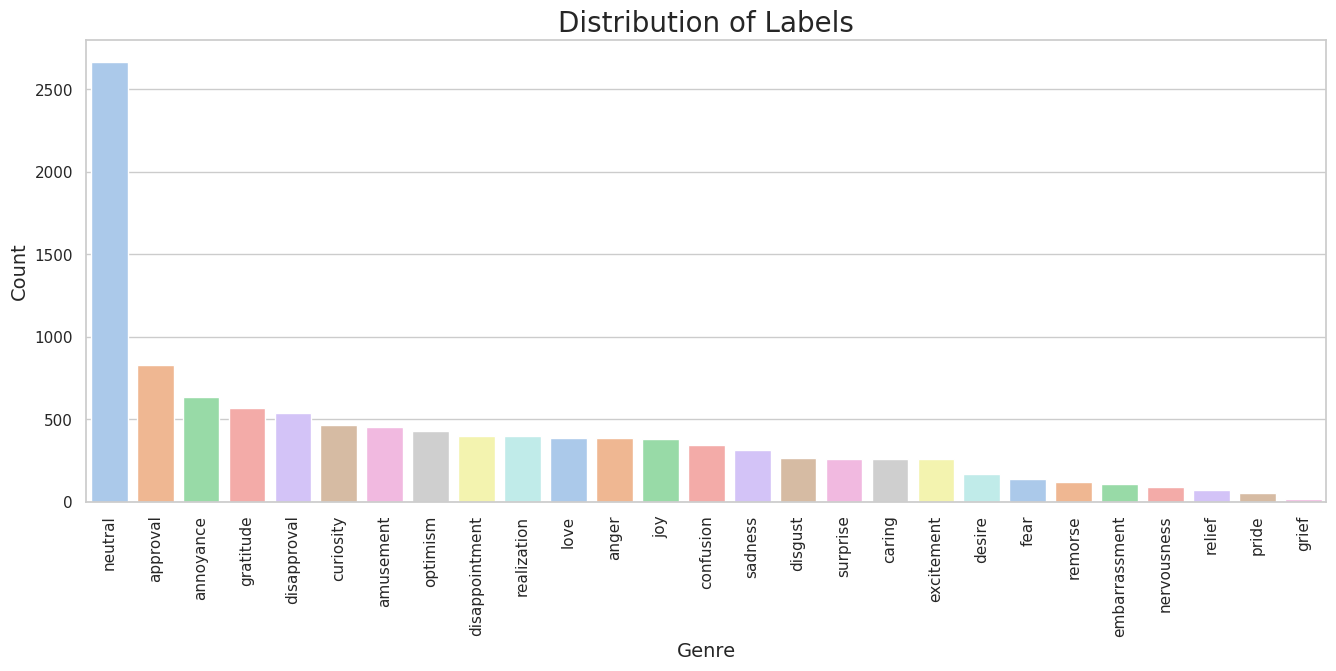

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set style and context
sns.set_style('whitegrid')
sns.set_context('notebook')

# Prepare the data
genre_counts = pd.Series(all_labels).value_counts()

# Create the plot
plt.figure(figsize=(16, 6))

colors = sns.color_palette('pastel')[0:len(genre_counts)]
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette=colors)

plt.title('Distribution of Labels', fontsize=20)
plt.xlabel('Genre', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=90)

# Show and save the plot
plt.show()

In [ ]:
unique_labels = sorted(list(set(all_labels)))

print(len(unique_labels), unique_labels)

27 ['amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'neutral', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise']


In [ ]:
id2label = {idx:label for idx, label in enumerate(unique_labels)}
label2id = {label:idx for idx, label in enumerate(unique_labels)}


In [ ]:
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

TEACHER_MODEL = 'bert-large-cased'

tokenizer = AutoTokenizer.from_pretrained(TEACHER_MODEL)

def preprocess_data(examples, text_col='text', label_col='labels'):
    one_hot_encoded_matrix = []
    text = examples[text_col]
    labels = examples[label_col]
    for label in labels:
        one_hot_encoded_matrix.append([1 if l in label else 0 for l in unique_labels])

    # Convert the one_hot_encoded_matrix to a LongTensor
    one_hot_encoded_matrix = [torch.tensor(o, dtype=torch.float32) for o in one_hot_encoded_matrix]

    # Encode the text
    encoding = tokenizer(text, truncation=True, max_length=256)

    # Add labels
    encoding["labels"] = one_hot_encoded_matrix

    return encoding


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [ ]:
# MAX_TEXT_LENGTH = 1_000
# if MAX_TEXT_LENGTH:
#     dataset = dataset.filter(lambda x: len(x['text']) < MAX_TEXT_LENGTH)

Filter:   0%|          | 0/168980 [00:00<?, ? examples/s]

Filter:   0%|          | 0/42245 [00:00<?, ? examples/s]

In [ ]:
encoded_dataset = dataset.map(preprocess_data, batched=True, batch_size=128)

encoded_dataset

Map:   0%|          | 0/168980 [00:00<?, ? examples/s]

Map:   0%|          | 0/42245 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'id', 'author', 'subreddit', 'link_id', 'parent_id', 'created_utc', 'rater_id', 'example_very_unclear', 'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 168980
    })
    test: Dataset({
        features: ['text', 'id', 'author', 'subreddit', 'link_id', 'parent_id', 'created_utc', 'rater_id', 'example_very_unclear', 'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pri

In [ ]:
len(encoded_dataset['train'][0]['input_ids'])

20

In [ ]:
# Import the necessary libraries
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
import torch
import numpy as np
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, jaccard_score, precision_score, recall_score

# Define a function to compute several multi-label metrics
def multi_label_metrics(predictions, labels, threshold=0.5):
    # Initialize the sigmoid function which we'll use to transform our raw prediction values
    sigmoid = torch.nn.Sigmoid()

    # Apply sigmoid function to our predictions
    probs = sigmoid(torch.Tensor(predictions))

    # Create a binary prediction array based on our threshold
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1

    # Use actual labels as y_true
    y_true = labels

    # Compute F1 score, ROC AUC score, Accuracy, and Jaccard score
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average='micro')
    accuracy = accuracy_score(y_true, y_pred)
    jaccard = jaccard_score(y_true, y_pred, average='micro')
    precision = precision_score(y_true, y_pred, average='micro')
    recall = recall_score(y_true, y_pred, average='micro')

    # Package the scores into a dictionary and return it
    metrics = {
        'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy,
               'jaccard': jaccard,
               'precision': precision,
               'recall': recall
        }
    return metrics

# Define a function to compute metrics for predictions
def compute_metrics(p: EvalPrediction):
    # Extract the prediction values from the EvalPrediction object
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions

    # Compute the multi-label metrics for the predictions and actual labels
    result = multi_label_metrics(predictions=preds, labels=p.label_ids)

    # Return the results
    return result


In [ ]:
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Train with normal BERT

In [ ]:
teacher_model = AutoModelForSequenceClassification.from_pretrained(
    TEACHER_MODEL,
    problem_type="multi_label_classification",
    num_labels=len(unique_labels),
    id2label=id2label,
    label2id=label2id
)

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
EPOCHS = 3

In [ ]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    output_dir="teacher-bert",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=16,  # effective batch size of 64
    per_device_eval_batch_size=64,
    num_train_epochs=EPOCHS,
    logging_steps=10,
    load_best_model_at_end=True,
    fp16=True,
    learning_rate=2e-5,
    warmup_ratio=0.1,
    lr_scheduler_type='cosine'
)

trainer = Trainer(
    teacher_model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.evaluate()

{'eval_loss': 0.6257067322731018,
 'eval_f1': 0.05821833534712295,
 'eval_roc_auc': 0.4739992108712018,
 'eval_accuracy': 0.0,
 'eval_jaccard': 0.029981916302382207,
 'eval_precision': 0.03340313471666984,
 'eval_recall': 0.22644269029746414,
 'eval_runtime': 35.8614,
 'eval_samples_per_second': 1178.008,
 'eval_steps_per_second': 18.432}

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy,Jaccard,Precision,Recall
0,0.112100,0.111386,0.308527,0.599834,0.232359,0.182401,0.624107,0.204913
1,0.102800,0.108915,0.334620,0.611676,0.247580,0.200927,0.618382,0.229368
2,0.099300,0.109416,0.360622,0.626549,0.272056,0.219975,0.583097,0.261029


TrainOutput(global_step=7920, training_loss=0.11962228253333256, metrics={'train_runtime': 11712.0905, 'train_samples_per_second': 43.283, 'train_steps_per_second': 0.676, 'total_flos': 2.778198275811576e+16, 'train_loss': 0.11962228253333256, 'epoch': 3.0})

In [ ]:
# trainer.evaluate(eval_dataset=encoded_dataset["valid"])

In [ ]:
trainer.save_model()

# Train with Distil BERT (Task-Agnostic Distilation)

In [ ]:
ta_distil_model = AutoModelForSequenceClassification.from_pretrained(
    'distilbert-base-cased',
    problem_type="multi_label_classification",
    num_labels=len(unique_labels),
    id2label=id2label,
    label2id=label2id
)

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    f"task-agnostic-distilbert",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=64,
    num_train_epochs=EPOCHS,
    logging_steps=10,
    load_best_model_at_end=True,
    fp16=True,
    learning_rate=2e-5,
    warmup_ratio=0.1,
    lr_scheduler_type='cosine'
)

ta_trainer = Trainer(
    ta_distil_model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

ta_trainer.evaluate()

{'eval_loss': 0.6984817981719971,
 'eval_f1': 0.0466455019326153,
 'eval_roc_auc': 0.40516215216686385,
 'eval_accuracy': 0.0,
 'eval_jaccard': 0.023879691053910367,
 'eval_precision': 0.02530415048002602,
 'eval_recall': 0.2978512894414213,
 'eval_runtime': 11.634,
 'eval_samples_per_second': 3631.172,
 'eval_steps_per_second': 56.816}

In [ ]:
ta_trainer.train()

Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy,Jaccard,Precision,Recall
0,0.116400,0.113137,0.271160,0.583455,0.206226,0.156845,0.659737,0.170649
2,0.108500,0.109893,0.330371,0.609469,0.246467,0.197871,0.623664,0.224700


TrainOutput(global_step=7920, training_loss=0.12881591982311671, metrics={'train_runtime': 985.9467, 'train_samples_per_second': 514.166, 'train_steps_per_second': 8.033, 'total_flos': 4862772610851168.0, 'train_loss': 0.12881591982311671, 'epoch': 3.0})

In [ ]:
# ta_trainer.evaluate(eval_dataset=encoded_dataset["valid"])

# (Task-Specific Distilation)

In [ ]:
from transformers import TrainingArguments, Trainer
import torch
import torch.nn as nn
import torch.nn.functional as F

# Custom TrainingArguments class to add distillation specific parameters
class DistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)

        # Alpha is the weight for the original student loss
        # A higher value means more focus on the student's original task
        self.alpha = alpha

        # Temperature parameter to soften probability distributions before calculating distillation loss
        # Higher value makes the distribution more uniform, carrying more information from the teacher model's outputs
        self.temperature = temperature

# Custom Trainer class to implement knowledge distillation
class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, **kwargs):
        super().__init__(*args, **kwargs)

        # The teacher model, a pre-trained model that the student model will learn from
        self.teacher = teacher_model

        # Move the teacher model to the same device as the student model
        # This is necessary for the computations in the forward pass
        self._move_model_to_device(self.teacher, self.model.device)

        # Set teacher model to eval mode because we only want to use it for inference, not for training
        self.teacher.eval()

    def compute_loss(self, model, inputs, return_outputs=False):
        # Compute the output of the student model on the inputs
        outputs_student = model(**inputs)
        # Original loss of the student model (e.g., cross entropy for classification)
        student_loss = outputs_student.loss

        # Compute the output of the teacher model on the inputs
        # We don't need gradients for the teacher model, so we use torch.no_grad to avoid unnecessary computation
        with torch.no_grad():
            outputs_teacher = self.teacher(**inputs)

        # Check that the sizes of the student and teacher outputs match
        assert outputs_student.logits.size() == outputs_teacher.logits.size()

        # Kullback-Leibler divergence loss function, comparing the softened output distributions of the student and teacher models
        loss_function = nn.KLDivLoss(reduction="batchmean")

        # Calculate the distillation loss between the student and teacher outputs
        # We apply log_softmax to the student's outputs and softmax to the teacher's outputs before calculating the loss
        # This is due to the expectation of log probabilities for the input and probabilities for the target in nn.KLDivLoss

        # Note multiplying by temperature^2 is not to punish the loss like we did during reward modeling for SAWYER..
        # It is done because we divided both student and teacher logits by temperature so this operation puts the loss
        # back on the same scale as student_loss, which we are about to combine using a weighted mean
        loss_logits = (loss_function(
            F.log_softmax(outputs_student.logits / self.args.temperature, dim=-1),
            F.softmax(outputs_teacher.logits / self.args.temperature, dim=-1)) * (self.args.temperature ** 2))

        # The total loss is a weighted combination of the student's original loss and the distillation loss
        loss = self.args.alpha * student_loss + (1. - self.args.alpha) * loss_logits

        # Depending on the return_outputs parameter, return either the loss alone or the loss and the student's outputs
        return (loss, outputs_student) if return_outputs else loss


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(TEACHER_MODEL)

teacher_model = AutoModelForSequenceClassification.from_pretrained(
    f"teacher-bert", problem_type="multi_label_classification",
).eval()


In [ ]:
# define student model
ts_distil_model = AutoModelForSequenceClassification.from_pretrained(
    'distilbert-base-cased',
    num_labels=len(unique_labels),
    id2label=id2label,
    label2id=label2id,
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# define training args
training_args = DistillationTrainingArguments(
    output_dir='task-specific-distilbert',
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    num_train_epochs=EPOCHS,
    logging_steps=10,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=64,
    load_best_model_at_end=True,
    alpha=0.3,
    temperature=2.0,
    fp16=True,
    learning_rate=2e-5,
    warmup_ratio=0.1,
    lr_scheduler_type='cosine'
    )


In [ ]:
ts_trainer = DistillationTrainer(
    ts_distil_model,
    training_args,
    teacher_model=teacher_model,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


In [ ]:
ts_trainer.evaluate()

{'eval_loss': 1.7064504623413086,
 'eval_f1': 0.08556322703563403,
 'eval_roc_auc': 0.5384727582076385,
 'eval_accuracy': 0.0,
 'eval_jaccard': 0.044693681318681316,
 'eval_precision': 0.04556721994723014,
 'eval_recall': 0.6998257802249801,
 'eval_runtime': 126.7988,
 'eval_samples_per_second': 333.166,
 'eval_steps_per_second': 5.213}

In [ ]:
ts_trainer.train()

Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy,Jaccard,Precision,Recall
0,0.137600,0.103033,0.397025,0.654413,0.290472,0.247680,0.518957,0.321489
2,0.085400,0.069835,0.376422,0.637185,0.285762,0.231847,0.558352,0.283914


TrainOutput(global_step=7920, training_loss=0.19167870295168174, metrics={'train_runtime': 2271.8125, 'train_samples_per_second': 223.143, 'train_steps_per_second': 3.486, 'total_flos': 4862772610851168.0, 'train_loss': 0.19167870295168174, 'epoch': 3.0})

In [ ]:
# ts_trainer.evaluate(eval_dataset=encoded_dataset["valid"])

In [ ]:
ts_trainer.save_model()

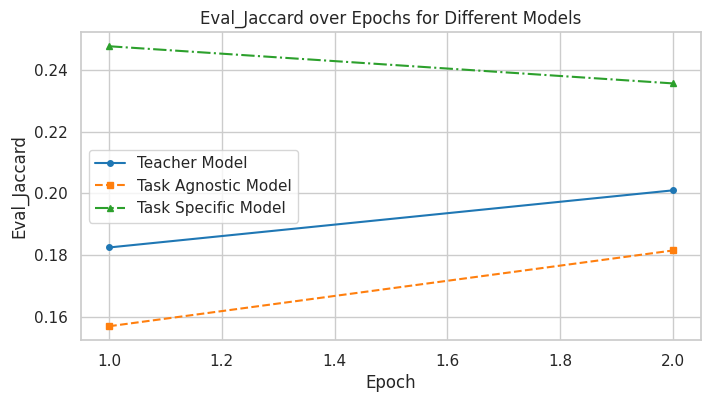

In [ ]:
import matplotlib.pyplot as plt

def plot_metric(metric):

    # Jaccard scores for each model (replace with your values)
    teacher_metrics = [_[metric] for _ in trainer.state.log_history if metric in _][:-1]
    agnostic_metrics = [_[metric] for _ in ta_trainer.state.log_history if metric in _][:-1]
    specific_metrics = [_[metric] for _ in ts_trainer.state.log_history if metric in _][:-1]

    range_epochs = range(1, len(teacher_metrics) + 1)

    plt.figure(figsize=(8, 4))
    plt.plot(range_epochs, teacher_metrics, marker='o', markersize=4, linestyle='-', label='Teacher Model')
    plt.plot(range_epochs, agnostic_metrics, marker='s', markersize=4, linestyle='--', label='Task Agnostic Model')
    plt.plot(range_epochs, specific_metrics, marker='^', markersize=4, linestyle='-.', label='Task Specific Model')

    plt.xlabel('Epoch')
    plt.ylabel(metric.title())
    plt.title(f'{metric.title()} over Epochs for Different Models')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_metric('eval_jaccard')

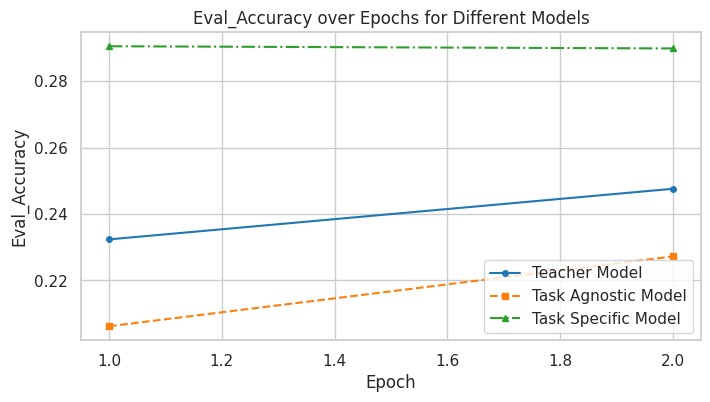

In [ ]:
plot_metric('eval_accuracy')

In [ ]:
# ts_val_metrics = ts_trainer.evaluate(eval_dataset=encoded_dataset["valid"])

# Using our models

In [ ]:
# Our base model
teacher_model = AutoModelForSequenceClassification.from_pretrained(
    f"teacher-bert", problem_type="multi_label_classification",
    id2label=id2label,
    label2id=label2id,
).eval().to(0)

# Our task specific model
task_specific_model = AutoModelForSequenceClassification.from_pretrained(
    'task-specific-distilbert',
    num_labels=len(unique_labels),
    id2label=id2label,
).eval().to(0)

In [ ]:
batch = data_collator(list(encoded_dataset['test'].select_columns(['labels', 'input_ids', 'attention_mask', 'token_type_ids']))[:32]).to(0)

In [ ]:
%timeit teacher_model(**batch)

66.6 ms ± 6.37 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
import time
from tqdm import tqdm

time_to_run_teacher = []
TIMES_TO_RUN = 10

for _ in tqdm(range(TIMES_TO_RUN)):
    start_time = time.time()
    teacher_model(**batch)
    end_time = time.time()
    time_to_run_teacher.append(end_time - start_time)

sum(time_to_run_teacher) / len(time_to_run_teacher)

100%|██████████| 10/10 [00:00<00:00, 15.38it/s]


0.062432360649108884

In [ ]:
distil_batch = {k: v for k, v in batch.items() if k != 'token_type_ids'}

In [ ]:
%timeit task_specific_model(**distil_batch)

14.8 ms ± 2.22 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
import time
from tqdm import tqdm

time_to_run_student = []
TIMES_TO_RUN = 10

for _ in tqdm(range(TIMES_TO_RUN)):
    start_time = time.time()
    task_specific_model(**distil_batch)
    end_time = time.time()
    time_to_run_student.append(end_time - start_time)

sum(time_to_run_student) / len(time_to_run_student)

100%|██████████| 10/10 [00:00<00:00, 81.31it/s]


0.011610031127929688

In [ ]:
# ^^ shows how our distilled model is over 6x faster

In [ ]:
# Count the number of parameters in the teacher_model
num_params_trained = sum(p.numel() for p in teacher_model.parameters())
print(f'Trained Model has {num_params_trained} parameters.')

# Print the data types of the parameters in the teacher_model
for p in teacher_model.parameters():
    print(f'Data type of the parameter in teacher_model: {p.dtype}')
    break  # We break after printing the first one assuming all parameters have the same dtype

# Count the number of parameters in the task_specific_model
num_params_task_specific = sum(p.numel() for p in task_specific_model.parameters())
print(f'Task Specific Model has {num_params_task_specific} parameters.')

# Print the data types of the parameters in the task_specific_model
for p in task_specific_model.parameters():
    print(f'Data type of the parameter in task_specific_model: {p.dtype}')
    break  # We break after printing the first one assuming all parameters have the same dtype

# Estimate the memory usage (in MB assuming parameters are stored as 32-bit floats)
memory_usage_trained = num_params_trained * 4 / (1024 ** 2)
memory_usage_task_specific = num_params_task_specific * 4 / (1024 ** 2)

print(f'Estimated memory for teacher_model: {memory_usage_trained} MB')
print(f'Estimated memory for task_specific_model: {memory_usage_task_specific} MB')


Trained Model has 333606939 parameters.
Data type of the parameter in teacher_model: torch.float32
Task Specific Model has 65802267 parameters.
Data type of the parameter in task_specific_model: torch.float32
Estimated memory for teacher_model: 1272.6094779968262 MB
Estimated memory for task_specific_model: 251.01572799682617 MB


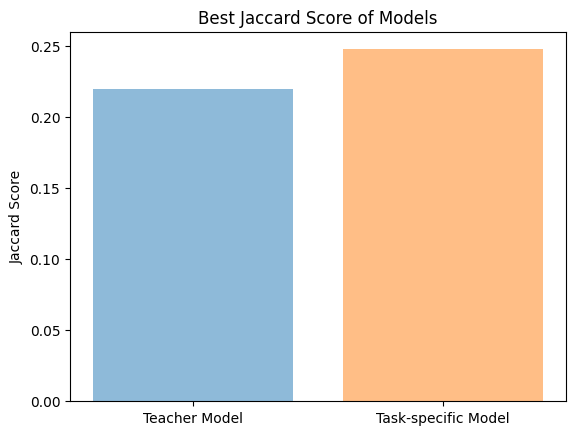

In [ ]:
import matplotlib.pyplot as plt

# Model names
models = ['Teacher Model', 'Task-specific Model']

# Estimated memory usage (in MB)


# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Generate a bar plot with patterns
bars = ax.bar(models, [0.219975, 0.247680], align='center', alpha=0.5, color=['#1f77b4', '#ff7f0e'])

# Add labels and title
ax.set_ylabel('Jaccard Score')
ax.set_title('Best Jaccard Score of Models')

# Display the plot
plt.show()


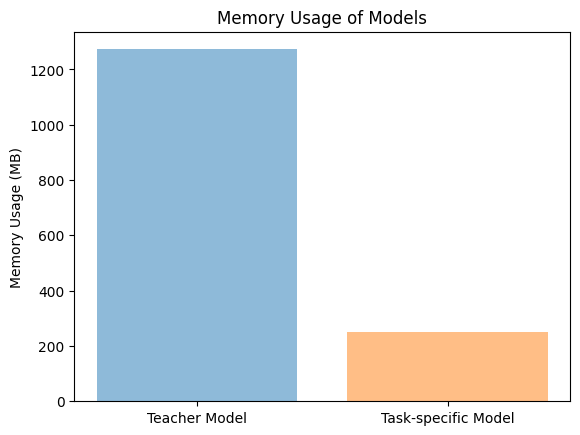

In [ ]:
import matplotlib.pyplot as plt

# Model names
models = ['Teacher Model', 'Task-specific Model']

# Estimated memory usage (in MB)
# memory_usage = [memory_usage_trained, memory_usage_task_specific]
memory_usage = [1272.6094, 251.015]
# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Generate a bar plot with patterns
bars = ax.bar(models, memory_usage, align='center', alpha=0.5, color=['#1f77b4', '#ff7f0e'])

# Add labels and title
ax.set_ylabel('Memory Usage (MB)')
ax.set_title('Memory Usage of Models')

# Display the plot
plt.show()


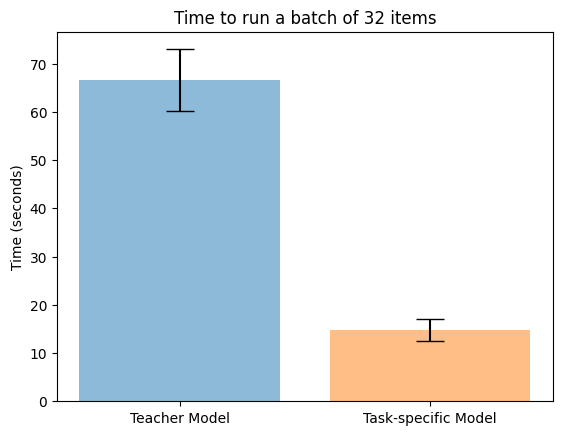

In [ ]:
import matplotlib.pyplot as plt

# Model names
models = ['Teacher Model', 'Task-specific Model']

# Times taken to run a batch of 32 items (in seconds)
times = [66.6, 14.8]

# Standard deviations
std_devs = [6.37, 2.22]

# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Generate a bar plot
ax.bar(models, times, yerr=std_devs, align='center', alpha=0.5, ecolor='black', capsize=10,  color=['#1f77b4', '#ff7f0e'])

# Add labels and title
ax.set_ylabel('Time (seconds)')
ax.set_title('Time to run a batch of 32 items')

# Display the plot
plt.show()
